# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of items that were ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below  
💪 But feel free to investigate into other hypothesis instead with part 3

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `review_costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need


⚠️ Don't start from scratch, update your existing package 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the items they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist enforce sellers to include certain information on their product listings?
- Should Olist ask customers for purchase confirmation at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import math

In [2]:
from olist.seller import Seller
seller = Seller()
seller_df = seller.get_training_data()
seller_df.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,subscription_fees,olist_sales_cut,share_of_five_stars,share_of_one_stars,review_score
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,320.0,21.870,1,1,3.000000
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,1120.0,1141.317,30,2,4.560976
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,0.0,15.800,1,0,5.000000
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,0.0,7.999,1,0,5.000000
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,0.0,16.799,0,1,1.000000



1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the items they sold



In [3]:
SUBSCRIPTION_FEE = 80  # per_M
SALES_FEE_RATE = 0.10  #  Olist takes a 10% cut on the product price (excl. freight) of each order delivered
alpha = 3157.27
beta = 978.23

In [4]:
IT_COST = alpha * math.sqrt(seller_df['seller_id'].count()) + beta * math.sqrt(seller_df['quantity'].sum())
IT_COST

499999.31851932954

In [5]:
def IT_cost(df):
    alpha = 3157.27
    beta = 978.23
    IT_costs = alpha * math.sqrt(df['seller_id'].count()) + beta * math.sqrt(df['quantity'].sum())
    return IT_costs


def IT_cost_without_seller(df,n_items):
    alpha = 3157.27
    beta = 978.23
    IT_costs = alpha * math.sqrt(df['seller_id'].count()-1) + beta * math.sqrt(df['quantity'].sum()-n_items)
    return IT_costs

In [6]:
cost = {1: 100,
2: 50,
3: 40
}


seller_df['it_cost'] = seller_df['quantity'].apply(lambda x: IT_COST-IT_cost_without_seller(seller_df,x))


seller_df['review_costs'] = seller_df['review_score'].apply(lambda x: cost.get(x, 0))

seller_df['costs'] = seller_df['it_cost'] + seller_df['review_costs']

# seller_df.head()

In [7]:


seller_df['sub_fees']  = seller_df['months_on_olist']*SUBSCRIPTION_FEE

seller_df['cut'] = seller_df['sales']*SALES_FEE_RATE

seller_df['revenues'] =seller_df['sub_fees'] + seller_df['cut']

# seller_df.head()

In [8]:

seller_df['profits'] = seller_df['revenues'] - seller_df['costs']
# seller_df.head()

2️⃣ Sort sellers by increasing profits

In [9]:
seller_df = seller_df.sort_values(by='profits', ascending=True).reset_index(drop=True)

# seller_df.head()

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

In [10]:
seller_neg_df=seller_df[['costs',	'revenues',	'profits']]
seller_neg_df=-(seller_neg_df)
seller_neg_df=seller_neg_df.cumsum()


In [11]:
seller_neg_df

,costs,revenues,profits
0,-130.442727,-0.690,1.297527e+02
1,-260.885454,-1.880,2.590055e+02
2,-391.328181,-3.130,3.881982e+02
3,-521.770909,-4.430,5.173409e+02
4,-655.130945,-9.390,6.457409e+02
...,...,...,...
2962,-257566.310680,-2697866.186,-2.440300e+06
2963,-258091.608422,-2717189.373,-2.459098e+06
2964,-258976.473142,-2738193.576,-2.479217e+06
2965,-259604.046497,-2761431.181,-2.501827e+06


Text(0, 0.5, 'Cumulative Financial Impact')

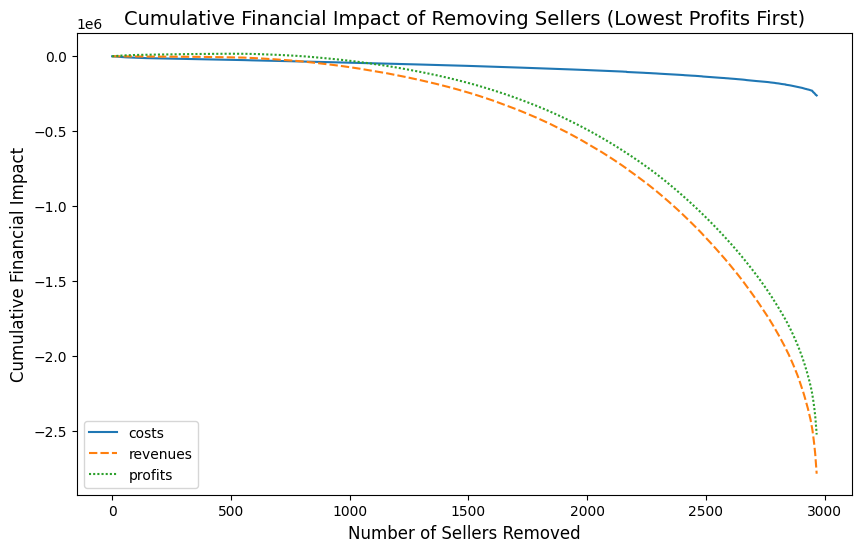

In [12]:
# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot the cumulative financial impact on profits, costs, and revenues
sns.lineplot(data=seller_neg_df)

# # Set plot labels and title
plt.title('Cumulative Financial Impact of Removing Sellers (Lowest Profits First)', fontsize=14)
plt.xlabel('Number of Sellers Removed', fontsize=12)
plt.ylabel('Cumulative Financial Impact', fontsize=12)


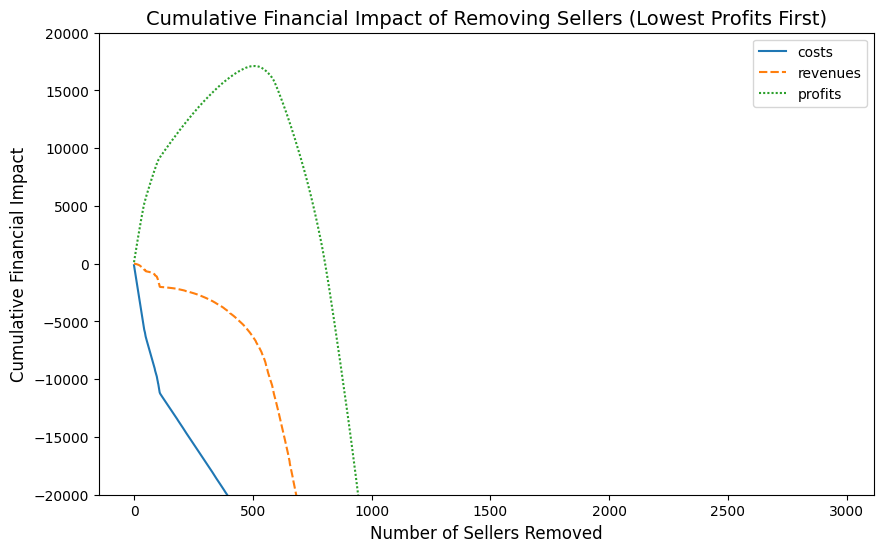

In [13]:
# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot the cumulative financial impact on profits, costs, and revenues
sns.lineplot(data=seller_neg_df)
plt.ylim([-20000, 20000])
# # Set plot labels and title
plt.title('Cumulative Financial Impact of Removing Sellers (Lowest Profits First)', fontsize=14)
plt.xlabel('Number of Sellers Removed', fontsize=12)
plt.ylabel('Cumulative Financial Impact', fontsize=12)

plt.show()






4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

 we need to remove the firist 508 sellers to make the profits positive


In [14]:

seller_df[seller_df['profits'] >0]
# we need to remove the firist 508 sellers to make the profits positive


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,share_of_five_stars,share_of_one_stars,review_score,it_cost,review_costs,costs,sub_fees,cut,revenues,profits
508,a81466620e46a6970b22ef40379fdfc9,sao ludgero,SC,0.0,7.190133,2017-10-11 10:28:13,2017-10-13 15:20:57,0.0,2,2,...,2,0,5.000000,31.901379,0,31.901379,0.0,32.180,32.180,0.278621
509,ebd1417732defaf66c50b5a800eb293e,londrina,PR,0.0,6.121713,2017-03-28 09:55:14,2017-03-28 09:55:14,0.0,1,1,...,1,0,5.000000,30.442727,0,30.442727,0.0,30.900,30.900,0.457273
510,f18112da765e0971ca5d510dec322bdd,brusque,SC,0.0,17.898137,2018-01-01 22:27:26,2018-01-02 19:32:22,0.0,2,2,...,0,0,4.000000,31.901379,0,31.901379,0.0,32.780,32.780,0.878621
511,3b18f9856c6eb2413eafedb58e9eecd9,santo andre,SP,0.0,9.184120,2018-04-13 12:50:24,2018-04-13 12:50:24,0.0,1,1,...,1,0,5.000000,30.442727,0,30.442727,0.0,31.500,31.500,1.057273
512,c611f4ce9ce875bcc063fa97fd4d7d12,atibaia,SP,0.0,4.072801,2018-07-31 15:40:18,2018-07-31 15:40:18,0.0,1,1,...,0,0,4.000000,30.442727,0,30.442727,0.0,31.900,31.900,1.457273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,1806,1987,...,947,294,3.803931,2940.224002,0,2940.224002,1600.0,20047.292,21647.292,18707.067998
2963,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,...,213,35,4.206490,525.297742,0,525.297742,1680.0,17643.187,19323.187,18797.889258
2964,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,...,394,50,4.340206,884.864720,0,884.864720,1600.0,19404.203,21004.203,20119.338280
2965,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,358,410,...,210,41,4.075980,627.573355,0,627.573355,960.0,22277.605,23237.605,22610.031645


In [15]:
from olist.order import Order
order = Order()
order_df = order.get_training_data()

In [16]:
from olist.data import Olist
data = Olist()
raw_data = data.get_data()

## 1.  Should Olist remove the worst performing products / categories from its marketplace entirely?

In [17]:
huge_products = raw_data['order_items'].merge(raw_data['products'], on = 'product_id').merge(raw_data['product_category_name_translation'], on = 'product_category_name')

huge_products

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.90,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.90,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.90,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111018,b99217b1fcf2fdeace7b8d869b76cb91,1,57bdf3098169cccdb62221bd3e089cbd,d98eec89afa3380e14463da2aabaea72,2018-03-13 17:55:36,39.99,10.15,fashion_roupa_infanto_juvenil,38.0,168.0,1.0,100.0,16.0,16.0,16.0,fashion_childrens_clothes
111019,bc3ac768a8963f4ca68942ea6558fc9f,1,57bdf3098169cccdb62221bd3e089cbd,d98eec89afa3380e14463da2aabaea72,2018-03-28 03:09:01,39.99,6.43,fashion_roupa_infanto_juvenil,38.0,168.0,1.0,100.0,16.0,16.0,16.0,fashion_childrens_clothes
111020,cab08f0417a702d0f4782ec02356a4ac,1,8cfc3506cedc0626364457d254429118,dbb9b48c841a0e39e21f98e1a6b2ec3e,2017-10-09 04:28:12,89.99,17.07,fashion_roupa_infanto_juvenil,47.0,327.0,3.0,300.0,30.0,20.0,20.0,fashion_childrens_clothes
111021,cb53f0b6e8f9082a9f5a113765dd1236,1,8cfc3506cedc0626364457d254429118,dbb9b48c841a0e39e21f98e1a6b2ec3e,2018-06-11 22:50:09,89.99,7.49,fashion_roupa_infanto_juvenil,47.0,327.0,3.0,300.0,30.0,20.0,20.0,fashion_childrens_clothes


In [18]:
filtered_huge_products = huge_products.loc[: , ['order_id', 'order_item_id', 'product_id', 'price', 'freight_value', 'product_category_name_english']]
filtered_huge_products = filtered_huge_products.sort_values(by='freight_value', ascending=False)

In [19]:
huge_products_rate = filtered_huge_products.merge(order_df, on = 'order_id')
huge_products_rate = huge_products_rate.loc[: , ['order_id', 'order_item_id', 'price_x', 'freight_value_x', 'product_category_name_english', 'wait_time', 'expected_wait_time', 'review_score']]

In [20]:
huge_products_rate = huge_products_rate.rename(columns={'price_x': 'price',
                                                       'freight_value_x' : 'freight_value'})

In [21]:
HUGE_ITEMS = 100
#filtered_items = huge_products_rate[huge_products_rate['freight_value'] >= HUGE_ITEMS]
filtered_items = huge_products_rate[(huge_products_rate['freight_value'] >= HUGE_ITEMS) &
                                    (huge_products_rate['wait_time'] > huge_products_rate['expected_wait_time']) &
                                    (huge_products_rate['review_score'] <= 3)]

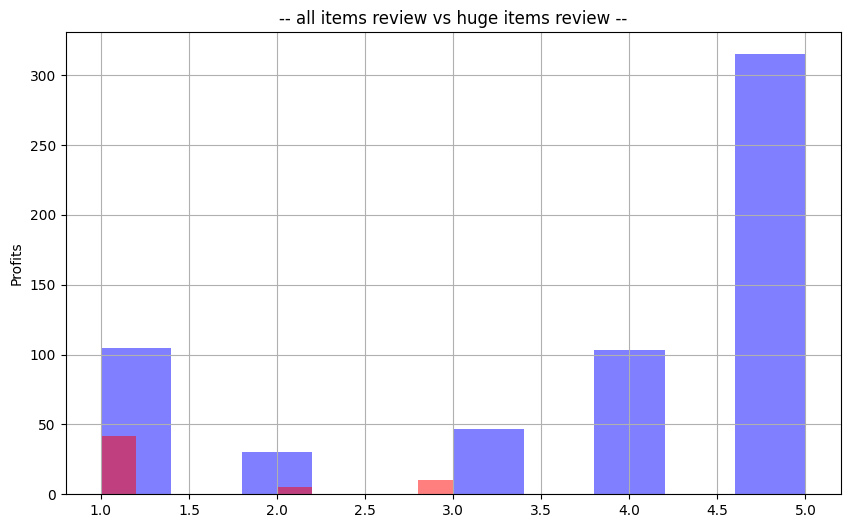

In [22]:
plt.figure(figsize=(10, 6))
# Plot histogram of profits before removing sampled sellers
plt.hist(huge_products_rate['review_score'].iloc[:600], bins=10, alpha=0.5, color='b', label='reviews for all items')
# Plot histogram of profits after removing sampled sellers
plt.hist(filtered_items['review_score'], bins=10, alpha=0.5, color='r', label='reivews for huge items')
plt.ylabel('Profits')
plt.grid(True)
plt.title('-- all items review vs huge items review --');

In [23]:
# the conclusion that may got:
# - About half of the orders rated 1 and some of orders rated 2 are huge items that were delayed.
# - Therefore, it may be better to deal with a seller who provides fast shipping companies for shipping large items.

## 2. 